In [ ]:
! pwd
! pip uninstall sympytorch -y

In [ ]:
import os
import sys


ROOT="/home/guillermo.carrilho/PhysicsSimulationDeepLearning"
#ROOT="/share_zeta/Proxy-Sim/PhysicsSimulationDeepLearning"

sys.path.append(os.path.join(ROOT,"Physical_models"))

# Differentiable physics with PINNs

In [ ]:
from random import randint
from Physical_models.Differentiable_simulation import Space2Tensor,Tensor2Space
from tqdm import tqdm
from Train_differentiable_physics_with_PINNs import PINNS_based_SOL_trainer

class PINNS_based_SOL_trainer(PINNS_based_SOL_trainer):
    
    def forward_prediction_correction_test(self):

      # FIELD FORMAT
      self.os_=self.v.geometry.center.native("x,y").shape
      # SQUARED TENSOR FORMAT
      XT=self.generate_postion_time_code(self.v,self.t)
      XTU=torch.concat((XT,Space2Tensor(self.v,self.geometry)),axis=1)

      # TABULAR TENSOR FORMAT
      states_pred=[rearrange(XTU,"b u x y-> b (x y) u").requires_grad_(True)]  # START OF FLUX
      XTUp_1,XTUp=self.correct(states_pred[-1])
      
      # OBS: correction is made in field forrmat, for no aparent reason (TODO: try to train in field format)
      states_in=[XTUp_1]
      states_corr=[XTUp]
      states_pred=[XTUp_1[:,:,-1:]+XTUp]

      # For steps in correction run (4 in example) (incidencia nos iniciais)
      for i in tqdm(range(self.n_steps_test)):
        
        # Step last in states_pred
        U_space=Tensor2Space(rearrange(states_pred[-1]," b (x y) u -> b u x y",x=self.os_[0],y=self.os_[1])[0],self.geometry)
        states_pred.append(self.ph_model.step(
          U_space
          ))
        #U_tensor=Space2Tensor(U_space,self.geometry)
        self.t=self.t+self.dt
        XT=self.generate_postion_time_code(U_space,self.t)
        XTU=torch.concat((XT,Space2Tensor(U_space,self.geometry)),axis=1)
        # GRAD HERE
        
        states_pred[-1]=rearrange(XTU,"b u x y-> b (x y) u")
        # Correct with model of last states_pred
        XTUp_1,XTUp=self.correct(states_pred[-1])

        states_in.append(XTUp_1)
        states_corr.append(XTUp)
        states_pred[-1]=XTUp_1[:,:,-1:]+XTUp

      return states_pred,states_corr,states_in
    
    def train(self,epochs):
      losses=[]
      for i in tqdm(range(epochs)):
        #tqdm.write(f"epoch {i}")
        co_batch=[]
        in_batch=[]
        for b in tqdm(range(20)):
          #tqdm.write(f"batch {b}")

          random_idx=randint(0,len(self.init_states_gt)-1)
          self.v=self.detach_field(self.init_states_gt[random_idx])
          self.t=self.T[random_idx]
          states_pred,states_corr,states_in=self.forward_prediction_correction()
          co_batch=co_batch+states_pred
          in_batch=in_batch+states_in

        loss=0
        for i,(u,x) in enumerate(zip(co_batch,in_batch)):
          sample_loss=self.loss(u,x)
          loss=loss+sample_loss

        #states_in=torch.concat(states_in,axis=0) # [B X Y U]
        #states_pred=torch.concat(states_pred,axis=0) # [B X Y U]
        #print("LOSS")
        #loss=self.loss(states_pred,states_in)


        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        loss=loss/self.n_steps
        losses.append(loss.cpu().detach().numpy())
      return losses
    
    def test(self,epochs, time_fine_frac,space_fine_frac):

      self.ph_model=self.physical_model_constructor(self.v.downsample(1/space_fine_frac),dt=self.dt)
      self.n_steps_test=int(self.n_steps*time_fine_frac)
      or_dt=self.ph_model.dt
      self.ph_model.dt=self.ph_model.dt/time_fine_frac
      self.dt=self.ph_model.dt/time_fine_frac
      self.st_model.eval()
      

      losses=[]
      for i in tqdm(range(epochs)):
        #tqdm.write(f"epoch {i}")
        co_batch=[]
        in_batch=[]
        for b in tqdm(range(20)):
          #tqdm.write(f"batch {b}")

          random_idx=randint(0,len(self.init_states_gt)-1)
          self.v=self.detach_field(self.init_states_gt[random_idx])
          self.t=self.T[random_idx]
          states_pred,states_corr,states_in=self.forward_prediction_correction_test()
          co_batch=co_batch+states_pred
          in_batch=in_batch+states_in

        loss=0
        for i,(u,x) in enumerate(zip(co_batch,in_batch)):
          sample_loss=self.loss(u,x)
          loss=loss+sample_loss

        loss=loss/self.n_steps_test
        losses.append(loss.cpu().detach().numpy())
      
      self.ph_model.dt=or_dt
      self.dt=or_dt
      return losses

## Diffusion

$$ u_t - \nabla \cdot (D(x)\nabla u) = s     $$

In [ ]:
from phi.torch.flow import *
#from phi.field import solve_linear
#from phi import math as math_phi
from phi.torch.flow import *

class diffusion_model(object):
  def __init__(self,field,dt,conductivity=0.3):
    self.field=field
    self.dt=dt
    self.conductivity=conductivity

  @jit_compile_linear
  def sharpen(self,x):
    return self.explicit_step(x)

  
  def explicit_step(self, v, dt):
    lap = laplace(v, 
                  weights=self.conductivity, 
                  #gradient=gradient, 
                  order=2, 
                  implicit=math.Solve,
                  #upwind=upwind,
                  correct_skew=False
                  )
    return v + dt*lap.with_extrapolation(v.boundary - v.boundary)  # remove constants from extrapolation
    #return diffuse.implicit(v, self.conductivity, self.dt)
  def step(self,v):
    #@jit_compile_linear
    def sharpen(x):
      return self.explicit_step(x,-self.dt)
    return math.solve_linear(sharpen, y=v, solve=Solve( x0=v) )



#@jit_compile_linear
#def momentum_eq(u, u_prev, dt, diffusivity=0.01):
#    diffusion_term = dt * diffuse.differential(u, diffusivity, correct_skew=False)
#    advection_term = dt * advect.differential(u, u_prev, order=1)
#    return u + advection_term + diffusion_term
#
#@jit_compile
#def implicit_time_step(v, dt):
#    v = math.solve_linear(momentum_eq, v, Solve(x0=v), u_prev=v, dt=-dt)
#    v, p = fluid.make_incompressible(v)
#    return v

In [ ]:
geo=UniformGrid(x=50, y=50,bounds=Box(x=10.0, y=10.0))
phi_w=Field( geo,values=tensor(0.0),
      boundary= {
          'x-': tensor(0.005),
          'x+': ZERO_GRADIENT,
          'y-': 0,
          'y+': 0
 })
phi_w



model=diffusion_model(phi_w,0.1,0.1)

In [ ]:
from phi.field import Grid, Field, laplace
for i in range(10):
    phi_w=model.step(phi_w)



In [ ]:
#plt.plot(phi_w_.values.native("x,y").numpy())
plt.imshow(phi_w.values.native("x,y").numpy())

In [ ]:
import torch
from einops import rearrange
import matplotlib.pyplot as plt
from DL_models.PINNS.utils import *

class simple_cnn_model(torch.nn.Module):
  def __init__(self):
    super(simple_cnn_model,self).__init__()

    self.conv1=torch.nn.Conv2d(4, 32, (9,9), padding=4)
    self.conv2=torch.nn.Conv2d(32, 64, (9,9), padding=4)
    self.conv3=torch.nn.Conv2d(64, 1, (9,9), padding=4)
    self.act1=torch.nn.ReLU()
    self.act2=torch.nn.ReLU()
    self.act3=torch.nn.Tanh()
  def forward(self,x):
    x=self.act1(self.conv1(x))
    x=self.act2(self.conv2(x))
    x=self.act3(self.conv3(x))*0.01
    #x=torch.clamp(x, min=-0.5, max=0.5)
    return x
  

#class composed_loss(object):

#from DL_models.PINNS.utils import x_grad

# def x_grad(u,x,i,n):
  """
  gradient of degree n wrt x for component i of u
  input:
  u and x are tensors with vectors object at dimension -1
  [b, n_vectors, vector_dimension]
  output:
  [b, n_vectors, input_vector_dimension]
  """


def composed_loss(p,x,conductivity=0.3):
  """
  u: [b x y p]
  x: [b x y (x y t)]
  """
  #p=rearrange(p,"b p x y-> b (x y) p")
  #x=rearrange(x,"b u x y-> b (x y) u")
  dpdt = x_grad(p,x,0,1)[...,2]
  x_1_grad = x_grad(p,x,0,1)[...,:2] # r
  con_tensor=torch.eye(2,2)*conductivity # [2, 2]
  k=torch.tensordot(con_tensor,x_1_grad,dims=([-1],[2]))
  x_2_grad = torch.sum(x_grad(p,x,0,1)[...,:2],axis=-1) # r

  return torch.abs(torch.mean(dpdt-k*x_2_grad))

In [ ]:
st_model=simple_cnn_model().train()
optimizer=torch.optim.Adam(st_model.parameters(),lr=1e-4)

In [ ]:
T=PINNS_based_SOL_trainer(
    field=phi_w,
    physical_model=diffusion_model,
    statistical_model=st_model,
    optimizer=optimizer,
    simulation_steps=5,
    time_step=0.01,
    loss=composed_loss
)

In [ ]:
from tqdm import tqdm
L_tr=[]
L_ts=[]

In [ ]:

for i in tqdm(range(2)):
    print("train step")
    L_tr.append(T.train(1))
    print("test step")
    L_ts.append(T.test(1,time_fine_frac=0.5,space_fine_frac=0.5))
    tqdm.write(f"train {L_tr[-1]},test {L_ts[-1]}")

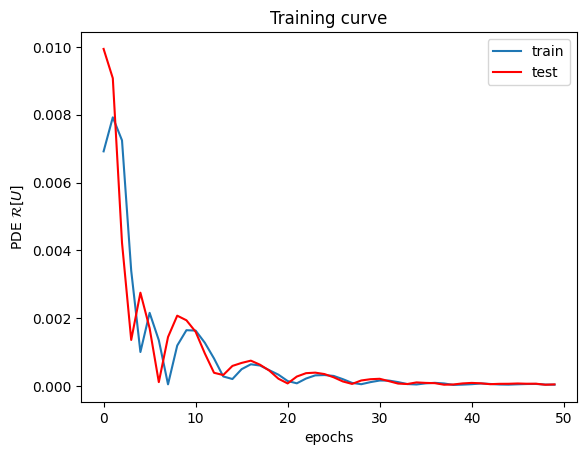

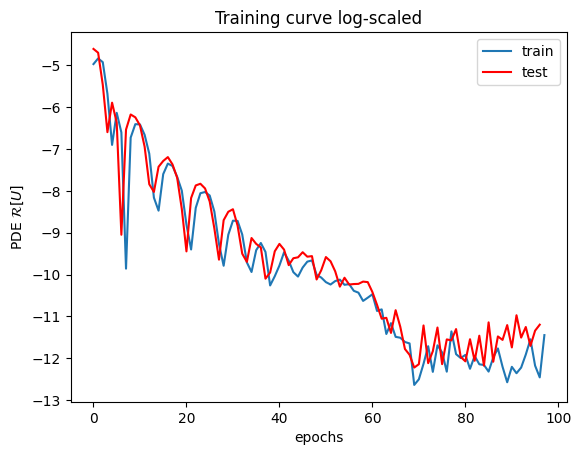

In [36]:
fig,axs=plt.subplots(1,1,
                     #figsize=(10,7)
                     )

#L_ts
axs.plot((L_tr[:50]),label="train")
axs.plot((L_ts[:50]),"r",label="test")
axs.set_title("Training curve")
axs.set_ylabel("PDE ${\cal{R}} [U]$")
axs.set_xlabel("epochs")
axs.legend()

fig,axs=plt.subplots(1,1,
                     #figsize=(10,7)
                     )
axs.set_title("Training curve log-scaled")
#L_ts
axs.plot(np.log(L_tr),label="train")
axs.plot(np.log(L_ts),"r",label="test")
axs.set_ylabel("PDE ${\cal{R}} [U]$")
axs.set_xlabel("epochs")
axs.legend()
plt.show()

In [34]:
print(L_tr[np.argmin(np.array(L_ts))])
print(L_ts[np.argmin(np.array(L_ts))])

[array(3.2525913e-06, dtype=float32)]
[array(4.921045e-06, dtype=float32)]


## Reaction-diffusion

In [ ]:
from phi.torch.flow import *
from phi import math as math_phi
class diffusion_model(object):
  def __init__(self,field,dt,conductivity=0.3):
    self.field=field
    self.dt=dt
    self.conductivity=conductivity

  def step(self, v):
    lap = laplace(v, 
                  weights=self.conductivity, 
                  #gradient=gradient, 
                  order=2, 
                  implicit=math_phi.Solve,
                  #upwind=upwind,
                  #correct_skew=correct_skew
                  )
    return lap.with_extrapolation(v.boundary - v.boundary)  # remove constants from extrapolation
    #return diffuse.implicit(v, self.conductivity, self.dt)
args={"k":0.1}

In [ ]:
geo=UniformGrid(x=20, y=20,bounds=Box(x=1.0, y=1.0))
phi_w=Field( geo,values=tensor(0.0),
      boundary= {
          'x-': tensor(0.01),
          'x+': ZERO_GRADIENT,
          'y-': 0,
          'y+': 0
 })
phi_w



model=diffusion_model(phi_w,0.1,0.3)

In [ ]:
#phi_w.geometry=UniformGrid(x=20, y=20,bounds=Box(x=1.0, y=1.0))
phi_w.downsample(4)

## 